In [1]:
import plotly.express as px
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle


from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

In [2]:
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
pd.read_pickle(train_test_splits_path)['test']

[162935,
 979984,
 200008,
 211922,
 989987,
 779370,
 108525,
 187850,
 351938,
 955465,
 173940,
 119833,
 692964,
 102513,
 251833,
 693764,
 103414,
 510225,
 973770,
 729254,
 782561,
 569965,
 728454,
 171330,
 113922,
 156536,
 169040,
 255740,
 132118,
 580650,
 102008,
 525541,
 156031,
 148032,
 112112,
 789373,
 765056,
 751550,
 104820,
 204521,
 130518,
 573249,
 130922,
 761957,
 210415,
 609143,
 952863,
 148941,
 160931,
 519647,
 283543,
 112920,
 349244,
 786569,
 346137,
 517239,
 368753,
 905147,
 224022,
 201717,
 144933,
 151021,
 214625,
 157437,
 576255,
 308129,
 257946,
 366042,
 166640,
 788876,
 627549,
 256540,
 645450,
 849264,
 492754,
 102311,
 182032,
 305830,
 173839,
 110613,
 580044,
 194847,
 210617,
 154936,
 680250,
 856968,
 599469,
 155635,
 102614,
 106521,
 117122,
 127832,
 198855,
 898176,
 120111,
 204218,
 877168,
 123117,
 107220,
 561242,
 727553,
 127630,
 201818,
 481951,
 110411,
 558960,
 211821,
 178243,
 745555,
 365343,
 152427]

In [3]:
mri_raw_file_path = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/151425/mri/T1.mgz'
seg_arr = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round2_segmentations/151425_upd/singletask_seg_all.npy')
assert seg_arr.shape == (256,256,256)

In [4]:
np.random.seed(2023)
unqs = np.unique(seg_arr)
print(unqs)
rand_nums = np.random.random((len(unqs), 3))
color_label_mapper = dict()
for i in range(len(unqs)):
    color_label_mapper[unqs[i]] = (rand_nums[i, :] * 255).astype('uint8')


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102.]


In [5]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

In [47]:
groups = [
    [0],
    [1, 13],
    [2, 14],
    [3, 15],
    [4, 5, 6]
]

groups = [
    ['Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter'],
    ['Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex','Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter'],
    ['Left-Caudate', 'Left-Putamen', 'Right-Caudate', 'Right-Putamen', 'Left-Pallidum', 'Right-Pallidum'],
    ['Brain-Stem'],
    ['Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC',
        'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC'],

    ['ctx-lh-inferiortemporal', 'ctx-lh-lateraloccipital',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
       'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal',
       'ctx-lh-parahippocampal', 'ctx-lh-parstriangularis',
       'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal',
       'ctx-lh-superiortemporal', 'ctx-lh-insula', 'ctx-rh-fusiform',
       'ctx-rh-inferiortemporal', 'ctx-rh-lateraloccipital',
       'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual',
       'ctx-rh-medialorbitofrontal', 'ctx-rh-middletemporal',
       'ctx-rh-parahippocampal', 'ctx-rh-parsorbitalis',
       'ctx-rh-parstriangularis', 'ctx-rh-rostralanteriorcingulate',
       'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiortemporal',
       'ctx-rh-insula']
]

groups = [
    ['Left-Caudate', 'Left-Putamen', 'Right-Caudate', 'Right-Putamen', 'Left-Pallidum', 'Right-Pallidum', 'Brain-Stem',
        'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC',
        'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
        'Left-choroid-plexus', 'Right-choroid-plexus']
    ['Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter', 
    'Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex','Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter'],
    ['ctx-lh-fusiform', 'ctx-lh-inferiortemporal', 'ctx-lh-lateraloccipital',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
       'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal',
       'ctx-lh-parahippocampal', 'ctx-lh-parstriangularis',
       'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal',
       'ctx-lh-superiortemporal', 'ctx-lh-insula', 'ctx-rh-fusiform',
       'ctx-rh-inferiortemporal', 'ctx-rh-lateraloccipital',
       'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual',
       'ctx-rh-medialorbitofrontal', 'ctx-rh-middletemporal',
       'ctx-rh-parahippocampal', 'ctx-rh-parsorbitalis',
       'ctx-rh-parstriangularis', 'ctx-rh-rostralanteriorcingulate',
       'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiortemporal',
       'ctx-rh-insula']
]


In [26]:
label_converter.compressed_to_name(np.unique(seg_arr[161,:,:]))

array(['Unknown', 'Left-Cerebral-White-Matter',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', 'Brain-Stem',
       'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area',
       'Left-VentralDC', 'Left-choroid-plexus',
       'Right-Cerebral-White-Matter', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Putamen', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
       'Right-vessel', 'Right-choroid-plexus', 'ctx-lh-fusiform',
       'ctx-lh-inferiortemporal', 'ctx-lh-lateraloccipital',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
       'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal',
       'ctx-lh-parahippocampal', 'ctx-lh-parstriangularis',
       'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal',
       'ctx-lh-superiortemporal', 'ctx-lh-insula', 'ctx-rh-fusiform',
       'ctx-rh-inferiortemporal', 'ctx-rh-l

In [9]:
mapo = {}
for i in range(103):
    xd = str(label_converter.compressed_to_name(i))
    mapo[xd] = i

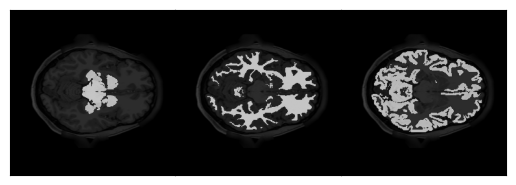

In [48]:
img = nib.load(mri_raw_file_path).get_fdata().astype(np.uint8)[:, 161, :]
img = np.repeat(img[:,:,None], 3, axis=-1)
img = img / 255.

fig, axs = plt.subplots(1, 3, squeeze=False)
ptr = 0

for grp in groups:
    r = ptr // 3
    c = ptr % 3
    this_mask = seg_arr[161,:,:] == -1 # initially all 0s
    for gg in grp:
        this_mask = np.maximum(this_mask, seg_arr[161,:,:] == mapo[gg])

    #this_mask = 1 - this_mask
    this_mask_img = np.repeat(this_mask[:,:,None], 3, axis=-1)
    blended = .4 * img + .6 * this_mask_img


    axs[r,c].imshow(blended, cmap='Greys')
    axs[r,c].get_xaxis().set_ticks([])
    axs[r,c].get_yaxis().set_ticks([])
    ptr+=1
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('/gpfs/home/kn2347/figs/segmentation_grouped_mask_plot.png', dpi=600)

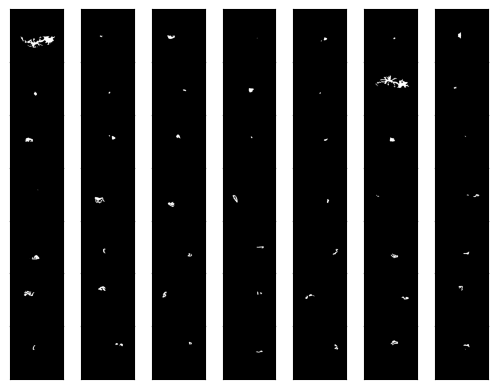

In [31]:

img = nib.load('/gpfs/data/cbi/hcp/hcp_seg/data_orig/151425/mri/T1.mgz').get_fdata().astype(np.uint8)


# for slice 111
fig, axs = plt.subplots(7, 7)
ptr=0
for unq_val in np.unique(seg_arr[161,:,:]):
    if unq_val == 0:
        continue
    r = ptr // 7
    c = ptr % 7
    this_mask = seg_arr[161,:,:] == unq_val
    #this_mask = this_mask[50:220, 50:220]
    axs[r,c].imshow(this_mask, cmap='Greys')

    axs[r,c].get_xaxis().set_ticks([])
    axs[r,c].get_yaxis().set_ticks([])
    #axs[r,c].axis('off')
    ptr+=1
fig.subplots_adjust(wspace=0, hspace=0)
#fig.tight_layout()